In [1]:
# import data
import pickle
from structs.types import Result

results: list[Result] = []

for i in range(16):
    with open(f"results/euclid/{i}.pkl", "rb") as reader:
        results.extend(pickle.load(reader))

In [2]:
# show sample data
print("==========")
print(f"gesture {results[0].gesture1} vs gesture {results[0].gesture2}")
print("----------")
print("location similarity:")
print(f"\tleft hand : {results[0].location_results[0]:.5f}")
print(f"\tright hand: {results[0].location_results[1]:.5f}")
print("motion error:")
print(f"\tleft shoulder : {results[0].motion_results[0]:.5f}")
print(f"\tright shoulder: {results[0].motion_results[1]:.5f}")
print(f"\tleft elbow    : {results[0].motion_results[2]:.5f}")
print(f"\tright elbow   : {results[0].motion_results[3]:.5f}")
print(f"\tleft wrist    : {results[0].motion_results[4]:.5f}")
print(f"\tright wrist   : {results[0].motion_results[5]:.5f}")
print("shape error:")
print(f"\tleft hand : {results[0].shape_results[0]:.5f}")
print(f"\tright hand: {results[0].shape_results[1]:.5f}")

gesture 0 vs gesture 0
----------
location similarity:
	left hand : 1.00000
	right hand: 0.99457
motion error:
	left shoulder : 0.50201
	right shoulder: 0.48968
	left elbow    : 0.50189
	right elbow   : 0.48956
	left wrist    : 0.50183
	right wrist   : 0.43354
shape error:
	left hand : 0.00000
	right hand: 45.30474


# Finding thresholds

Now that we've run our dataset through the modules, now we have to actually see what values would give us the best stats

In [3]:
# given the processed results, find the stats given a threshold
def thresholdTesterFactory(false_condition):

    def testThreshold(results: list[Result], threshold: float):
        true_pos = 0
        true_neg = 0
        false_pos = 0
        false_neg = 0

        for result in results:
            if (false_condition(result, threshold)):
                if result.gesture1 == result.gesture2:
                    false_neg += 1
                    continue

                true_neg += 1
                continue

            if result.gesture1 == result.gesture2:
                true_pos += 1
                continue

            false_pos += 1

        return true_pos, true_neg, false_pos, false_neg

    return testThreshold

In [4]:
# find optimal threshold
import matplotlib.pyplot as plt
import numpy as np


def plotThresholds(test_func, start, end, scale=1000, title="Thresholds", results=results):
    thresholds = [i / scale for i in range(start, end)]
    accuracies = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        print(f"threshold: {threshold}  ", end="\r")

        true_pos, true_neg, false_pos, _ = test_func(results, threshold)
        accuracy = (true_pos + true_neg) / len(results)

        all_positive = true_pos + false_pos
        precision = true_pos / all_positive if all_positive > 0 else 0

        all_true = true_pos + true_neg
        recall = true_pos / all_true if all_true > 0 else 0

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    np_thresholds = np.array(thresholds)
    np_accuracies = np.array(accuracies)
    np_precisions = np.array(precisions)
    np_recalls = np.array(recalls)

    plt.plot(np_thresholds, np_accuracies, color="r", label="accuracy")
    plt.plot(np_thresholds, np_precisions, color="g", label="precision")
    plt.plot(np_thresholds, np_recalls, color="b", label="recall")

    plt.title(title)
    plt.legend()
    plt.show()

## Location

In [5]:
def locationCondition(result, threshold):
    return result.location_results[0] < threshold or result.location_results[1] < threshold


test_location = thresholdTesterFactory(locationCondition)

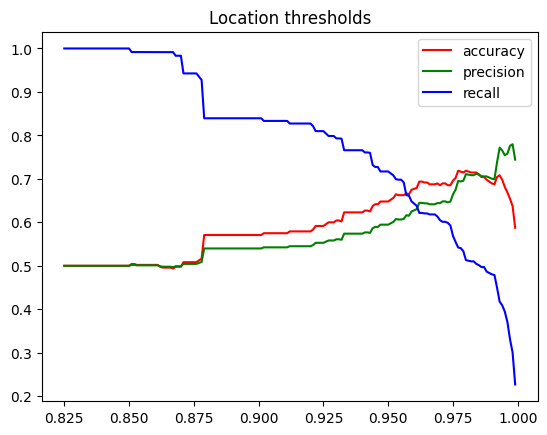

In [6]:
plotThresholds(test_location, 825, 1000, title="Location thresholds")

## Motion

In [7]:
def motionCondition(result, threshold):
    return (result.motion_results[0] >= threshold
            or result.motion_results[1] >= threshold
            or result.motion_results[2] >= threshold
            or result.motion_results[3] >= threshold
            or result.motion_results[4] >= threshold
            or result.motion_results[5] >= threshold)


test_motion = thresholdTesterFactory(motionCondition)

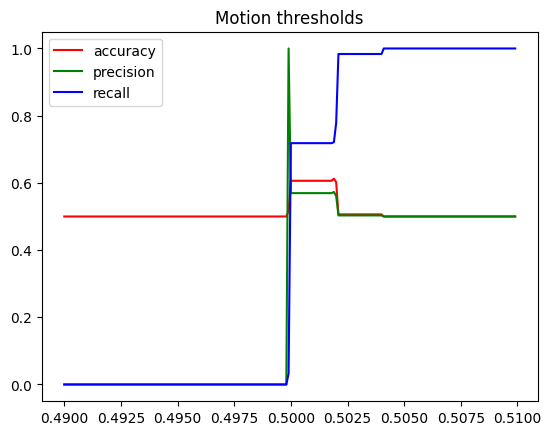

In [8]:
plotThresholds(test_motion, 4900, 5100, 10000, title="Motion thresholds")

## Shape (Euclidean Distance)

In [9]:
def shapeCondition(result, threshold):
    return (result.shape_results[0] >= threshold
            or result.shape_results[1] >= threshold)

test_shape = thresholdTesterFactory(shapeCondition)

threshold: 8.384  

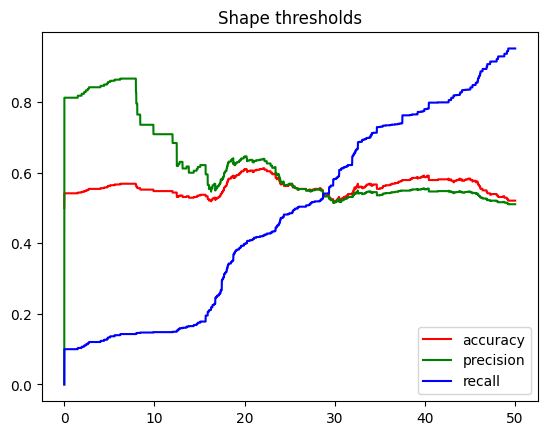

In [10]:
plotThresholds(test_shape, 0, 50000, title="Shape thresholds")

## Shape (Cosine Similarity)

In [11]:
cosine_results: list[Result] = []

for i in range(16):
    with open(f"results/cosine/{i}.pkl", "rb") as reader:
        cosine_results.extend(pickle.load(reader))

def shapeCosineCondition(result, threshold):
    return (result.shape_results[0] < threshold
            or result.shape_results[1] < threshold)

test_shape = thresholdTesterFactory(shapeCosineCondition)

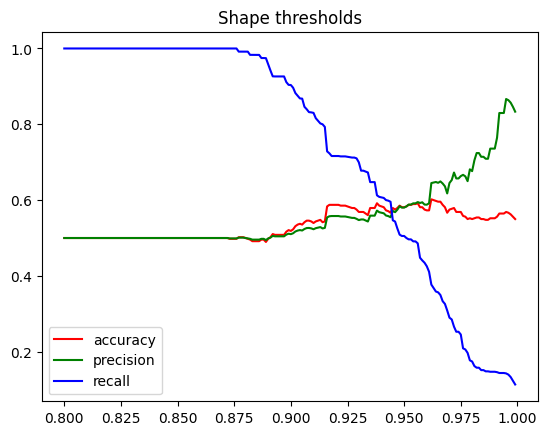

In [12]:
plotThresholds(test_shape, 800, 1000, title="Shape thresholds", results=cosine_results)